In [1]:
import os
import re
import time
import math
import json

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt
from skimage.transform import resize

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
class CrackClassifier(nn.Module):
    def __init__(self):
        super(CrackClassifier, self).__init__()
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    
    return acc

100%|██████████| 8/8 [00:52<00:00,  6.56s/it]


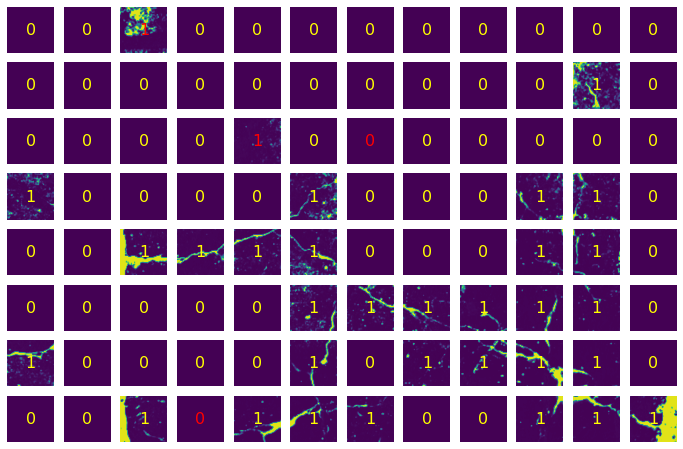

In [3]:
class MozaicSet(Dataset):
    def __init__(self, file, label=0, scale=.5, shape=(224,224)):
        self.scale = scale
        self.shape = shape
        
        self.image = plt.imread(file)
        _shape = self.image.shape
        self.image = resize(self.image, (_shape[0]*scale, _shape[1]*scale))
        _shape = self.image.shape
        
        self.size = shape[0]
        self.height, self.width = _shape[0]//self.size, _shape[1]//self.size
        self.label = [label for i in range(int(self.width*self.height))]
        
    def __len__(self):
        return self.height*self.width

    def __getitem__(self, idx):
        y, x = idx//self.width, idx%self.width
        img = self.image[y*self.size:y*self.size+self.size,
                         x*self.size:x*self.size+self.size]
        img = np.einsum("XYC->CXY", img)
        label = self.label[idx]

        return img, label

model_bi = CrackClassifier()
model_bi.load_state_dict(torch.load("models/binary_multi/crack_binary_c_344.torch"))
model_bi.eval()
model_bi.double()

model_ae = ConvAutoencoder()
model_ae.load_state_dict(torch.load(f"models/mask_2/crack_mask_c_90.torch"))
model_ae.eval()
model_ae.double()

mozaic = MozaicSet("image2.jpg" , (224,224), scale=.5)
loader = DataLoader(mozaic, batch_size=mozaic.width)
height, width = mozaic.height, mozaic.width
fig, ax = plt.subplots(height, width, figsize=(width, height))

labels = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,1,0,],
    [0,0,0,0,0,0,1,0,0,0,0,0,],
    [1,0,0,0,0,1,0,0,0,1,1,0,],
    [0,0,1,1,1,1,0,0,0,1,1,0,],
    [0,0,0,0,0,1,1,1,1,1,1,0,],
    [1,0,0,0,0,1,0,1,1,1,1,0,],
    [0,0,1,1,1,1,1,0,0,1,1,1,],
])

for y, (img, label) in enumerate(tqdm(loader)):
    _, pred = torch.max(model_bi(img), 1)
    pred = np.array(pred).flatten()
    for x in range(len(pred)):
        ax[y][x].set_axis_off()
        
        if pred[x]:
            tile = np.einsum("CXY->XYC", img[x])
            tile = np.dot(tile[...,:3], [.21, .72, .07]).reshape(-1, 224, 224)
            tile = torch.from_numpy(tile).reshape(-1, *tile.shape)
            ax[y][x].imshow(torch.detach(model_ae(tile)).numpy()[0][0])
        else: ax[y][x].imshow([[0]])
        ax[y][x].text(.4,.4, s=pred[x], fontsize=16, transform=ax[y][x].transAxes,
                      color="yellow" if pred[x]==labels[y][x] else "r")
    del(_, pred)
        
    plt.plot()

100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


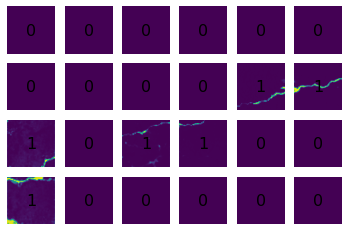

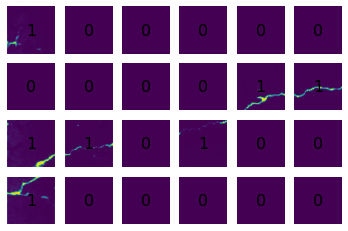

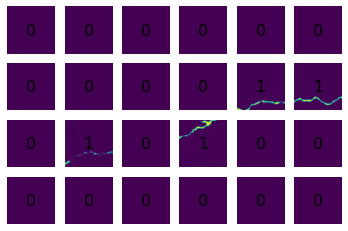

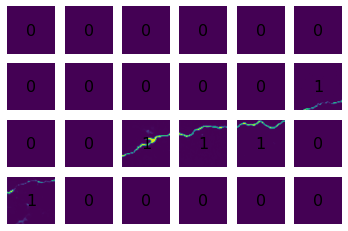

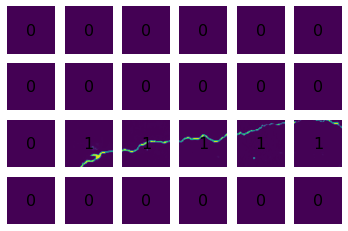

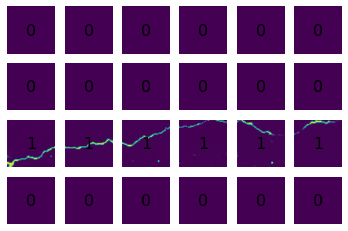

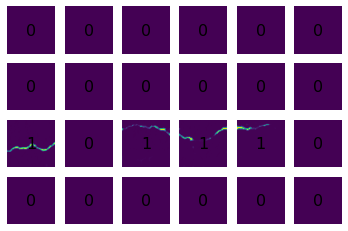

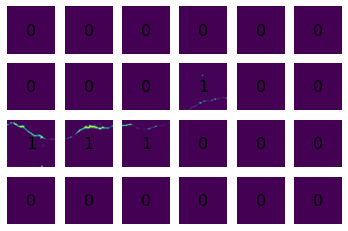

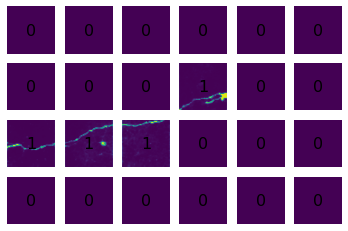

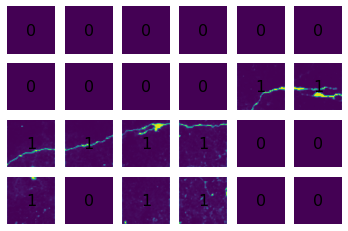

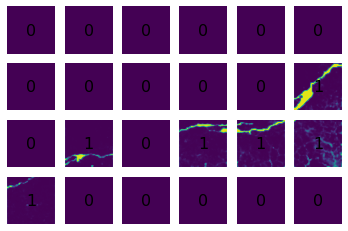

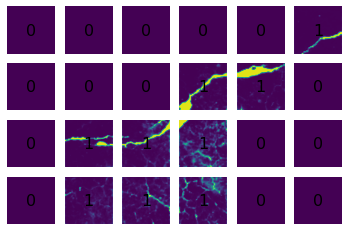

In [3]:
class MozaicSet(Dataset):
    def __init__(self, file, label=0, scale=.5, shape=(224,224)):
        self.scale = scale
        self.shape = shape
        
        self.image = plt.imread(file)
        _shape = self.image.shape
        self.image = resize(self.image, (_shape[0]*scale, _shape[1]*scale))
        _shape = self.image.shape
        
        self.size = shape[0]
        self.height, self.width = _shape[0]//self.size, _shape[1]//self.size
        self.label = [label for i in range(int(self.width*self.height))]
        
    def __len__(self):
        return self.height*self.width

    def __getitem__(self, idx):
        y, x = idx//self.width, idx%self.width
        img = self.image[y*self.size:y*self.size+self.size,
                         x*self.size:x*self.size+self.size]
        img = np.einsum("XYC->CXY", img)
        label = self.label[idx]

        return img, label

model_bi = CrackClassifier()
model_bi.load_state_dict(torch.load("models/crack_binary_c_088.torch"))
model_bi.eval()
model_bi.double()

model_ae = ConvAutoencoder()
model_ae.load_state_dict(torch.load(f"models/mask_2/crack_mask_c_90.torch"))
model_ae.eval()
model_ae.double()

for file in sorted(filter(lambda f: ".jpg" in f, os.listdir("concrete/TB"))):
    mozaic = MozaicSet("concrete/TB/" +file, (224,224), scale=.25)
    loader = DataLoader(mozaic, batch_size=mozaic.width)
    height, width = mozaic.height, mozaic.width
    fig, ax = plt.subplots(height, width, figsize=(width, height))
    
    for y, (img, label) in enumerate(tqdm(loader)):
        _, pred = torch.max(model_bi(img), 1)
        pred = np.array(pred).flatten()
        for x in range(len(pred)):
            ax[y][x].set_axis_off()
            
            if pred[x]:
                tile = np.einsum("CXY->XYC", img[x])
                tile = np.dot(tile[...,:3], [.21, .72, .07]).reshape(-1, 224, 224)
                tile = torch.from_numpy(tile).reshape(-1, *tile.shape)
                ax[y][x].imshow(torch.detach(model_ae(tile)).numpy()[0][0])
            else: ax[y][x].imshow([[0]])
            ax[y][x].text(.4,.4, s=pred[x], fontsize=16, transform=ax[y][x].transAxes)
        del(_, pred)
        
    plt.plot()

In [10]:
import imageio
imageio.mimsave("concrete/TB/gif/crack.gif", duration=.2, ims=[
    plt.imread("concrete/TB/gif/" +file) for file in sorted(os.listdir("concrete/TB/gif"))
])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [3]:
#root_dir = "/home/becode/Projects/Skyebase/mozaic"
root_dir = "/home/becode/Projects/Skyebase/concrete/TB"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
    
concrete_dataset = datasets.ImageFolder(
    root = root_dir,
    transform = transform
)

loader = DataLoader(dataset=concrete_dataset, shuffle=True, batch_size=8)

In [4]:
device = torch.device("cpu")

model = CrackClassifier()
model.load_state_dict(torch.load("crack_binary_c_xx.torch"))
model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
    
epoch = 1 
history = []
while True:    

    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    length = len(loader)
    tenth = length//10
    start = abs_start = time.time()
    for i, (X_train_batch, y_train_batch) in enumerate(loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
    #print(f"Train: done\t", f"{length} batches in {round((time.time() -abs_start)/60, 2)} minutes.\n")

    y_train_pred = model(X_train_batch).squeeze()
    train_loss = criterion(y_train_pred, y_train_batch)
    train_acc = binary_acc(y_train_pred, y_train_batch)
    train_loss.backward()
    optimizer.step()
    train_epoch_loss += train_loss.item()
    train_epoch_acc += train_acc.item()
    
    print(f"Epoch{epoch+0:03}\tAcc:{train_acc}\tloss:{train_loss}")
    history.append(train_acc)
    torch.save(model.state_dict(), f"models/crack_binary_c_{epoch+0:03}.torch")
    if all(map(lambda f: f > 90, history[-8:])): break
    if all(map(lambda f: f > 80, history[-10:])): print("10 IN A ROW")
        
    epoch += 1

/home/becode/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch001	Acc:88.0	loss:89.13011932373047
10 IN A ROW
Epoch002	Acc:62.0	loss:189.32135009765625
Epoch003	Acc:62.0	loss:95.74237060546875
Epoch004	Acc:75.0	loss:53.76323318481445
Epoch005	Acc:62.0	loss:105.30762481689453
Epoch006	Acc:62.0	loss:128.14096069335938
Epoch007	Acc:88.0	loss:18.821575164794922
Epoch008	Acc:62.0	loss:85.46640014648438
Epoch009	Acc:88.0	loss:63.094749450683594
Epoch010	Acc:88.0	loss:40.775360107421875
Epoch011	Acc:75.0	loss:8.773038864135742
Epoch012	Acc:75.0	loss:60.781124114990234
Epoch013	Acc:75.0	loss:27.01289939880371
Epoch014	Acc:88.0	loss:26.955211639404297
Epoch015	Acc:62.0	loss:96.29656982421875
Epoch016	Acc:38.0	loss:59.976593017578125
Epoch017	Acc:38.0	loss:72.5103988647461
Epoch018	Acc:75.0	loss:23.221603393554688
Epoch019	Acc:88.0	loss:32.84955596923828
Epoch020	Acc:88.0	loss:52.89895248413086
Epoch021	Acc:62.0	loss:74.7386474609375
Epoch022	Acc:75.0	loss:59.66168212890625
Epoch023	Acc:62.0	loss:93.4612808227539
Epoch024	Acc:88.0	loss:76.271377563476

In [3]:
model_bi = CrackClassifier()
#model_bi.load_state_dict(torch.load("models/crack_binary_c_344.torch"))
model_bi.load_state_dict(torch.load("models/crack_binary_c_088.torch"))
model_bi.eval()
model_bi.double()

CrackClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [4]:
model_ae = ConvAutoencoder()
model_ae.load_state_dict(torch.load(f"models/mask_2/crack_mask_c_90.torch"))
model_ae.eval()
model_ae.double()

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [5]:
class MozaicSet(Dataset):
    def __init__(self, file, label=0, scale=.5, shape=(224,224)):
        self.scale = scale
        self.shape = shape
        
        self.image = plt.imread(file)
        _shape = self.image.shape
        self.image = resize(self.image, (_shape[0]*scale, _shape[1]*scale))
        _shape = self.image.shape
        
        self.size = shape[0]
        self.height, self.width = _shape[0]//self.size, _shape[1]//self.size
        self.label = [label for i in range(int(self.width*self.height))]
        
    def __len__(self):
        return self.height*self.width

    def __getitem__(self, idx):
        y, x = idx//self.width, idx%self.width
        img = self.image[y*self.size:y*self.size+self.size,
                         x*self.size:x*self.size+self.size]
        img = np.einsum("XYC->CXY", img)
        label = self.label[idx]

        return img, label

In [5]:
image1_labels = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,1,0,0,],
    [0,0,0,0,0,1,1,0,0,0,0,0,],
    [0,0,0,0,1,1,0,0,1,1,0,0,],
    [0,0,1,1,1,1,0,0,0,1,0,0,],
    [0,0,0,0,0,1,1,1,1,1,0,0,],
    [1,0,0,0,1,1,0,1,1,1,1,0,],
    [0,0,1,1,1,1,0,0,1,0,1,0,],
])
image2_labels = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,1,0,],
    [0,0,0,0,0,0,1,0,0,0,0,0,],
    [1,0,0,0,0,1,0,0,0,1,1,0,],
    [0,0,1,1,1,1,0,0,0,1,1,0,],
    [0,0,0,0,0,1,1,1,1,1,1,0,],
    [1,0,0,0,0,1,0,1,1,1,1,0,],
    [0,0,1,1,1,1,1,0,0,1,1,1,],
])

In [6]:
def tile_to_mask(tile):
    result = np.einsum("CXY->XYC", img[0])
    result = np.dot(test[...,:3], [.21, .72, .07]).reshape(-1, 224, 224)
    result = torch.from_numpy(test).reshape(-1, *test.shape)
    return torch.detach(model_ae(result)).numpy()

100%|██████████| 4/4 [00:00<00:00, 54.19it/s]


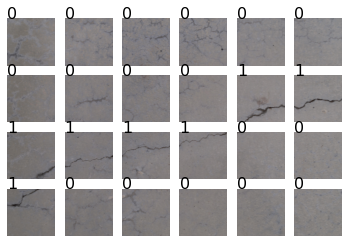

In [13]:
mozaic = MozaicSet("concrete/TB/" +os.listdir("concrete/TB")[3], (224,224), scale=.25)
loader = DataLoader(mozaic, batch_size=mozaic.width)

height, width = mozaic.height, mozaic.width
fig, ax = plt.subplots(height, width, figsize=(width, height))

for y, (img, label) in enumerate(tqdm(loader)):
    pred = np.array([
        [0,0,0,0,0,0],
        [0,0,0,0,1,1],
        [1,1,1,1,0,0],
        [1,0,0,0,0,0],
    ])
    #pred = np.array(pred).flatten()
    for x in range(len(img)):
        ax[y][x].set_axis_off()
        tile = np.einsum("CXY->XYC", img[x])
        ax[y][x].text(.1,.1,pred[y][x],fontsize=16)
        ax[y][x].imshow(tile)

In [ ]:
label_dict = {0:"Negative/", 1:"Positive/"}

for y in range(height):
    for x in range(width):
        plt.imsave("/home/becode/Projects/Skyebase/mozaic/" +label_dict[image1_labels[y][x]] +f"image1_{y}_{x}.png",
                   np.einsum("CXY->XYC", imozaic[y][x]))

In [ ]:
label_dict = {0:"Negative/", 1:"Positive/"}
for file in os.listdir("concrete/TB"):
    if file in ["Negative", "Positive"]: continue
    img = plt.imread("concrete/TB/" +file)
    shape = img.shape
    img = resize(img, (shape[0]*.25, shape[1]*.25))

    size = 224
    shape = img.shape
    height, width = shape[0]//size, shape[1]//size

    imozaic = np.einsum("HWXYC->HWCXY", np.array([
        img[y*size:y*size+size,x*size:x*size+size]
         for y in range(height)
          for x in range(width)
    ]).reshape(height, width, 224, 224, 3))
    
    for y in range(height):
        for x in range(width):
            plt.imsave("/home/becode/Projects/Skyebase/concrete/TB/Labeled/" 
                      +label_dict[file_dict[file][0][y][x]] +f"{file}_{y}_{x}.png",
                       np.einsum("CXY->XYC", imozaic[y][x]))
    del(img, imozaic)

In [12]:
file_dict = {
    "DMC - DSC01539.jpg" : [[
        [0,0,0,0,0,1],
        [0,0,0,1,1,0],
        [1,1,1,0,0,0],
        [0,0,0,0,0,0],
    ]],
    "DMC - DSC01529.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,1,1],
        [1,1,1,1,0,0],
        [1,0,0,0,0,0],
    ]],
    "DMC - DSC01534.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [1,1,1,1,1,0],
        [1,0,0,0,0,0],
    ]],
    "DMC - DSC01531.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,0,1],
        [0,1,1,1,1,0],
        [1,0,0,0,0,0],
    ]],
    "DMC - DSC01538.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,0,1],
        [0,1,1,1,1,0],
        [1,0,0,0,0,0],
    ]],
    "DMC - DSC01532.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [0,1,1,1,1,1],
        [1,1,0,0,0,0],
    ]],
    "DMC - DSC01536.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,1,1,1],
        [1,1,1,0,0,0],
        [0,0,0,0,0,0],
    ]],
    "DMC - DSC01528.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,1,1],
        [1,1,1,1,0,0],
        [1,0,0,0,0,0],
    ]],
    "DMC - DSC01535.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,1,1,1],
        [1,1,1,0,0,0],
        [0,0,0,0,0,0],
    ]],
    "DMC - DSC01533.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
        [1,1,1,1,1,1],
        [0,0,0,0,0,0],
    ]],

    "DMC - DSC01537.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,1,1],
        [1,1,1,1,0,0],
        [0,0,0,0,0,0],
    ]],
    "DMC - DSC01530.jpg" : [[
        [0,0,0,0,0,0],
        [0,0,0,0,1,1],
        [1,1,1,1,0,0],
        [1,0,0,0,0,0],
    ]]
}
#with open("concrete/TB/labels.json", "w") as file:
#    json.dump(label_dict, file)

In [ ]:
mozaic = MozaicSet("concrete/TB/DMC - DSC01528.jpg", (224,224), scale=.25)
loader = DataLoader(mozaic, batch_size=mozaic.width)
height, width = mozaic.height, mozaic.width
fig, ax = plt.subplots(height, width, figsize=(width, height))

#labels = image2_labels
for y, (img, label) in enumerate(tqdm(loader)):
    _, pred = torch.max(model_bi(img), 1)
    pred = np.array(pred).flatten()
    for x in range(len(pred)):
        ax[y][x].set_axis_off()
        ax[y][x].imshow(np.einsum("CXY->XYC", img[x]))
        if pred[x]:
            tile = np.einsum("CXY->XYC", img[x])
            tile = np.dot(tile[...,:3], [.21, .72, .07]).reshape(-1, 224, 224)
            tile = torch.from_numpy(tile).reshape(-1, *tile.shape)
            ax[y][x].imshow(torch.detach(model_ae(tile)).numpy()[0][0])
        else: ax[y][x].imshow([[0]])
        ax[y][x].text(.4,.4, s=pred[x], fontsize=16, transform=ax[y][x].transAxes)
                      #color="yellow" if pred[x]==labels[y][x] else "r")
    del(_, pred)

# Manual labels

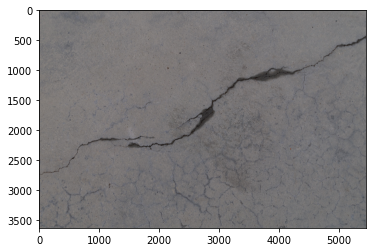

In [8]:
concrete_path = "concrete/TB"
plt.imshow(plt.imread(os.path.join(concrete_path, os.listdir("concrete/TB")[0])))

plt.hlines()
#image = plt.imread("concrete/T")

In [ ]:
label_dict = {0:"Negative/", 1:"Positive/"}

for y in range(height):
    for x in range(width):
        plt.imsave("/home/becode/Projects/Skyebase/mozaic/" +label_dict[image1_labels[y][x]] +f"image1_{y}_{x}.png",
                   np.einsum("CXY->XYC", imozaic[y][x]))